### Unsupervised Data Mining

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

### Problem_1: Dimension Reduction

With Problem_1, we aim to have a better understanding of dimension reduction with PCA. We will use Delta Airline data. Delta and other major airlines have data on all of their aircrafts on their website. [e.g.](https://www.delta.com/content/www/en_US/traveling-with-us/airports-and-aircraft/Aircraft.html)"

In [3]:
df = pd.read_csv('delta.csv', index_col='Aircraft')


In [4]:
df.head()

,Seat Width (Club),Seat Pitch (Club),Seat (Club),Seat Width (First Class),Seat Pitch (First Class),Seats (First Class),Seat Width (Business),Seat Pitch (Business),Seats (Business),Seat Width (Eco Comfort),...,Video,Power,Satellite,Flat-bed,Sleeper,Club,First Class,Business,Eco Comfort,Economy
Aircraft,,,,,,,,,,,,,,,,,,,,,
Airbus A319,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A319 VIP,19.4,44,12,19.4,40.0,28,21.0,59.0,14,0.0,...,1,0,0,0,0,1,1,1,0,0
Airbus A320,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A320 32-R,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,...,0,0,0,0,0,0,1,0,1,1
Airbus A330-200,0.0,0,0,0.0,0.0,0,21.0,60.0,32,18.0,...,1,1,0,1,0,0,0,1,1,1


First, let's look at the attributes related to the aircraft physical characteristics:

Cruising Speed (mph)
Range (miles)
Engines
Wingspan (ft)
Tail Height (ft)
Length (ft)
These six variables are about in the middle of the data frame (and it's part of your task to figure out where they are located).

Write a function named plot_pairgrid() that takes a pandas.DataFrame and uses seaborn.PairGrid to visualize the attributes related to the six physical characteristics listed above. The plots on the diagonal should be histograms of corresponding attributes, and the off-diagonal should be scatter plots.

In [5]:

def plot_pairgrid(df):
    '''
    Uses seaborn.PairGrid to visualize the attributes related to the six physical characteristics.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from importing delta.csv.
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    features = df.iloc[:, 16:22]
    sns.set(style="white")
    g = sns.PairGrid(features)
    g = g.map_offdiag(plt.scatter)
    ax = g.map_diag(plt.hist)
    return ax

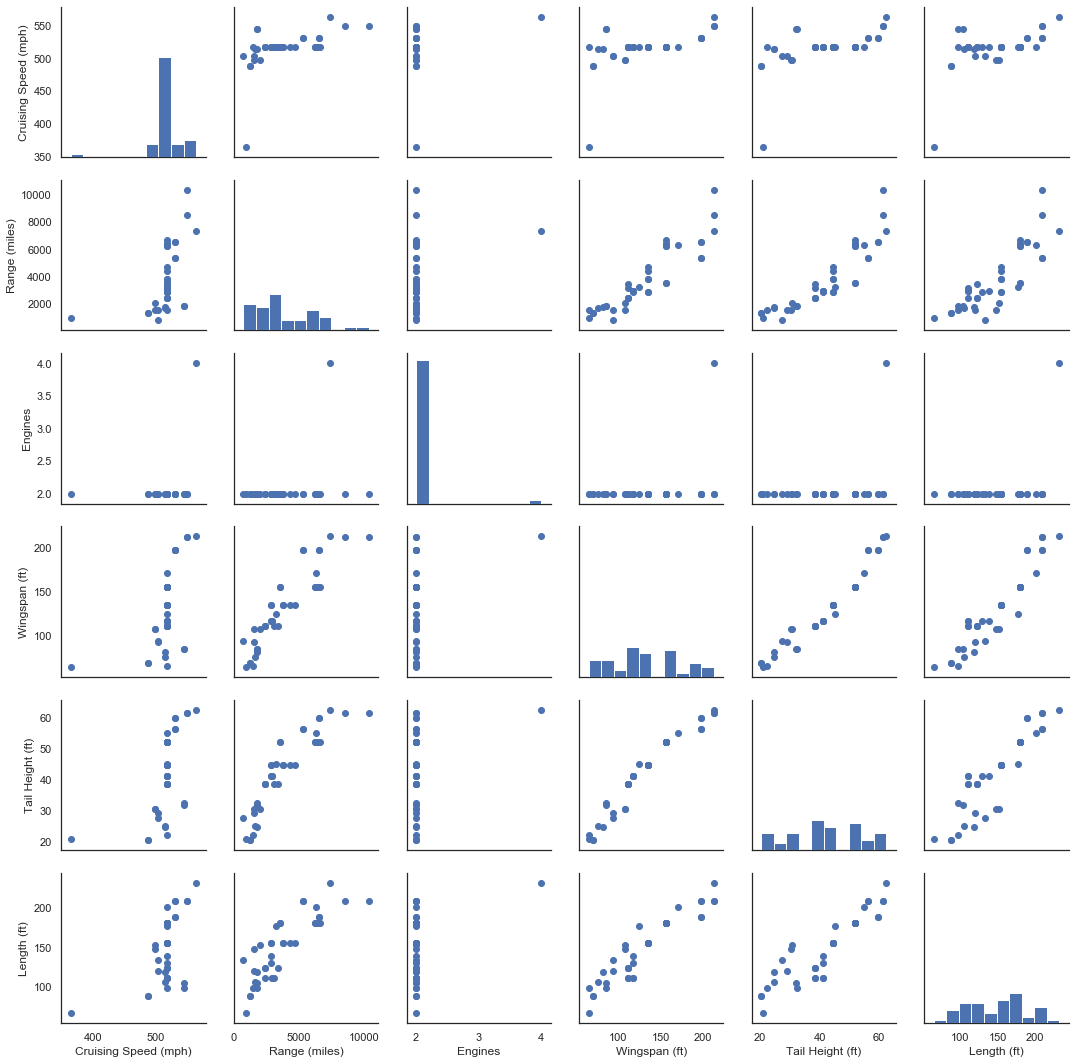

In [6]:
pg = plot_pairgrid(df) #your answer should look like this

We observe that pretty strong positive correlations between all these variables, as most of them are related to the aircraft’s overall size. Remarkably there is an almost perfectly linear relationship between wingspan and tail height.

The exception here is engines. There is one outlier which has four engines, while all the other aircraft have two. In this way the engines variable is really more like a categorical variable, but we shall as the analysis progresses that this is not really important, as there are other variables which more strongly discern the aircraft from one another than this.

In [7]:
### This is the unittest cell, please just run this cell without any modification once you generated "pg" above

cols = ['Cruising Speed (mph)', 'Range (miles)', 'Engines',
        'Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']

assert_is_instance(pg.fig, plt.Figure)
assert_equal(set(pg.data.columns), set(cols))

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 10)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

#### Apply PCA
I assume we dont know anything about dimensionality reduction techniques and just naively apply principle components to the data.

Write a function named fit_pca() that takes a pandas.DataFrame and uses [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to fit a PCA model on all values of df.

In [8]:
 def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    An sklearn.decomposition.pca.PCA instance.
    '''
    
    model = PCA(n_components)
    pca = model.fit(df)
    return pca
    
    
    


In [9]:
# we keep all components by setting n_components = no of cols in df. FYI df.shape[0] returns # of rows, len(df.columns) also works similar
pca_naive = fit_pca(df, n_components=df.shape[1])

In [10]:
assert_is_instance(pca_naive, PCA)
assert_almost_equal(pca_naive.explained_variance_ratio_.sum(), 1.0, 3)
assert_equal(pca_naive.n_components_, df.shape[1])
assert_equal(pca_naive.whiten, False)

In [11]:
def plot_naive_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Attributes are not scaled, hence a naive approach.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)
    return ax

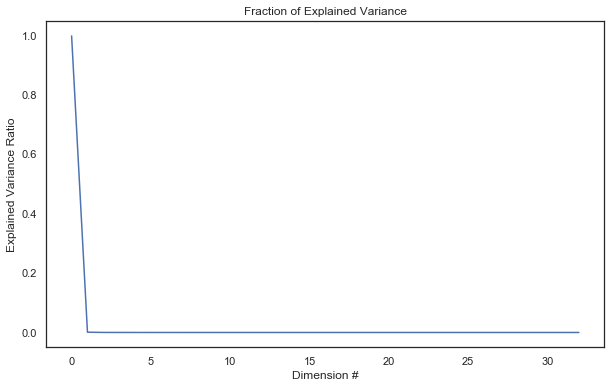

In [12]:
naive_var = plot_naive_variance(pca_naive)

In [13]:
assert_is_instance(naive_var, mpl.axes.Axes)
assert_equal(len(naive_var.lines), 1)

assert_is_not(len(naive_var.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(naive_var.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(naive_var.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

xdata, ydata = naive_var.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(df.shape[1])))
assert_array_almost_equal(ydata, pca_naive.explained_variance_ratio_)

In [22]:
abs_val = np.abs(pca_naive.components_[0])
max_pos = abs_val.argmax()
max_val = abs_val.max()

print('"{0}" accounts for {1:0.3f} % of the variance.'.format(df.columns[max_pos], max_val))

"Range (miles)" accounts for 0.999 % of the variance.


Taking this naive approach, we can see that the first principal component accounts for 99.9% of the variance in the data. (Note the y-axis is on a log scale.) Looking more closely, can we see that the first principle component is just the range in miles? This is because the scale of the different variables in the data set is quite variable.

PCA is a scale-dependent method. For example, if the range of one column is [-100, 100], while the that of another column is [-0.1, 0.1], PCA will place more weight on the feature with larger values. One way to avoid this is to standardize a data set by scaling each feature so that the individual features all look like Gausssian distributions with zero mean and unit variance. 

Please write a function named standardize() where StandardScaler function of sklearn will be used to scale each feature so that they have zero mean and unit variance.

In [23]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)
    return scaled

In [24]:
scaled = standardize(df)


In [25]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )

In [26]:
# we keep only 10 components
n_components = 10
pca = fit_pca(scaled, n_components=n_components)

Let's take another look to the explained variance of the first 10 principal components from the scaled data.

In [27]:
def plot_scaled_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Features are scaled with sklearn.StandardScaler.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)
    return ax

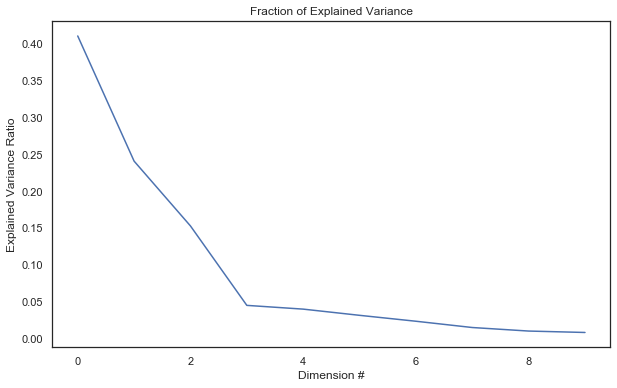

In [28]:
ax = plot_scaled_variance(pca)

In [29]:
assert_is_instance(ax, mpl.axes.Axes)
assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

xdata, ydata = ax.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(n_components)))
assert_array_almost_equal(ydata, pca.explained_variance_ratio_)

Nice, it looks good to go. There are various rules of thumb for selecting the number of principal components to retain in an analysis of this type, one of which I’ve experienced about is:

Pick the number of components which explain 85% or greater of the variation.
So, we will keep the first 4 principal components (remember that we are counting from zero, so we are keeping 0th, 1st, 2nd, and 3rd components—four components). Later in this assignment, we will use these four components to fit a $k$-means model. Before we move on to the next problem, let's apply the dimensional reduction on the scaled data. (In the previous sections, we didn't actually have to apply  transform(). This step is to make sure that the scaled data is actually "transformed".)

Write a function named reduce() that takes a PCA model (that is already trained on array) and a Numpy array, and applies dimensional reduction on the array.

In [30]:
def reduce(pca, array):
    '''
    Applies the `pca` model on array.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.PCA instance.
    
    Returns
    -------
    A Numpy array
    '''
    
    reduced = pca.transform(array)
    return reduced

In [31]:
reduced = reduce(pca, scaled)

In [32]:
assert_is_instance(reduced, np.ndarray)
assert_array_almost_equal(reduced, pca.fit_transform(scaled))

In [33]:
# Save the reduced data to the same directory of your notebook  as 'delta_reeuced.npy' that we will use later on
np.save('delta_reduced.npy', reduced)

### Problem 2. Clustering

We will use the first 10 principal components of the Delta Airline data set that we created in the first step.


In [34]:
##Standard imports just in case

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

In [35]:
## Reload the the first 10 components of delta dataset
reduced = np.load('delta_reduced.npy')


Write a function named cluster() that fits a k-means clustering algorithm, and returns a tuple (sklearn.cluster.k_means_.KMeans, np.array). The second element of the tuple is a 1-d array that contains the predictions of k-means clustering, i.e. which cluster each data point belongs to. Please remember how we were generating and using the labels for seeds, movements, iris etc.


Use default values for all parameters in KMeans() execept for n_clusters and random_state.

In [36]:
def cluster(array, random_state, n_clusters):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    kmeans = KMeans(n_clusters=n_clusters, init = 'k-means++', max_iter = 400, n_init = 10, random_state = random_state)
    model = kmeans.fit(array)
    clusters = model.predict(array)    
      
    return model, clusters

#here we return fitted (model) and predicted (clusters) arrays as a tuple

In [37]:
k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(1), n_clusters=5)

assert_is_instance(k_means_t, sklearn.cluster.k_means_.KMeans)
assert_is_instance(cluster_t, np.ndarray)
assert_equal(k_means_t.n_init, 10)
assert_equal(k_means_t.n_clusters, 5)
assert_equal(len(cluster_t), len(reduced))
assert_true((cluster_t < 5).all()) # n_cluster = 5 so labels should be between 0 and 5
assert_true((cluster_t >= 0).all())
labels_gold = -1. * np.ones(len(reduced), dtype=np.int)
mindist = np.empty(len(reduced))
mindist.fill(np.infty)
for i in range(5):
    dist = np.sum((reduced - k_means_t.cluster_centers_[i])**2., axis=1)
    labels_gold[dist < mindist] = i
    mindist = np.minimum(dist, mindist)
assert_true((mindist >= 0.0).all())
assert_true((labels_gold != -1).all())
assert_array_equal(labels_gold, cluster_t)

The scikit-learn documentation on sklearn.cluster.KMeans says that [Kmeans cluster](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) has the inertia value in the inertia_ attribute. So we can vary the number of clusters in KMeans, plot KMeans.inertia_ as a function of the number of clusters, and pick the "elbow" in the plot.

Always use check_random_state(0) to seed the random number generator.


In [39]:
def plot_inertia(array, start=1, end=11):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    inertia = []
    for i in range(start, end):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 400, n_init = 10, random_state=0)
        kmeans.fit(array)
        inertia.append(kmeans.inertia_)
    x_axis = range(start, end)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.plot(x_axis, inertia)
    

    return ax

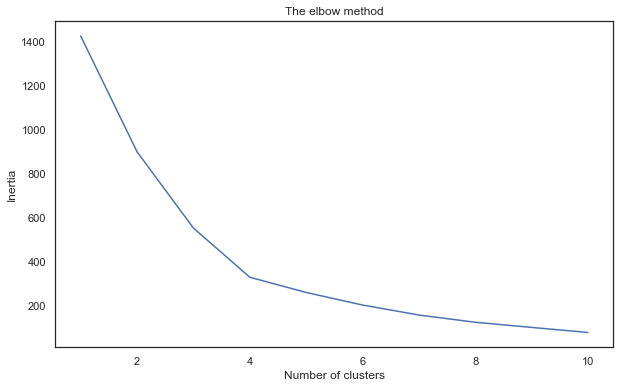

In [40]:
inertia = plot_inertia(reduced)

In [41]:
assert_is_instance(inertia, mpl.axes.Axes)
assert_true(len(inertia.lines) >= 1)

xdata, ydata = inertia.lines[0].get_xydata().T

for i in range(1, 11):
    k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(0), n_clusters=i)
    assert_array_equal(xdata[i - 1], i)
    assert_almost_equal(ydata[i - 1], k_means_t.inertia_)

assert_is_not(len(inertia.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(inertia.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(inertia.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

In [42]:
def plot_pair(reduced, clusters):
    '''
    Uses seaborn.PairGrid to visualize the data distribution
    when axes are the first four principal components.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    reduced: A numpy array. Comes from importing delta_reduced.npy
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    df = pd.DataFrame(reduced)
    df['c'] = clusters
    subset = [0,1,2,3, 'c']
    columns = [0,1,2,3]
    
    ax = sns.PairGrid(df[subset], vars = columns, hue = 'c')
    ax = ax.map_diag(plt.hist)
    ax = ax.map_offdiag(plt.scatter)
    
    return ax

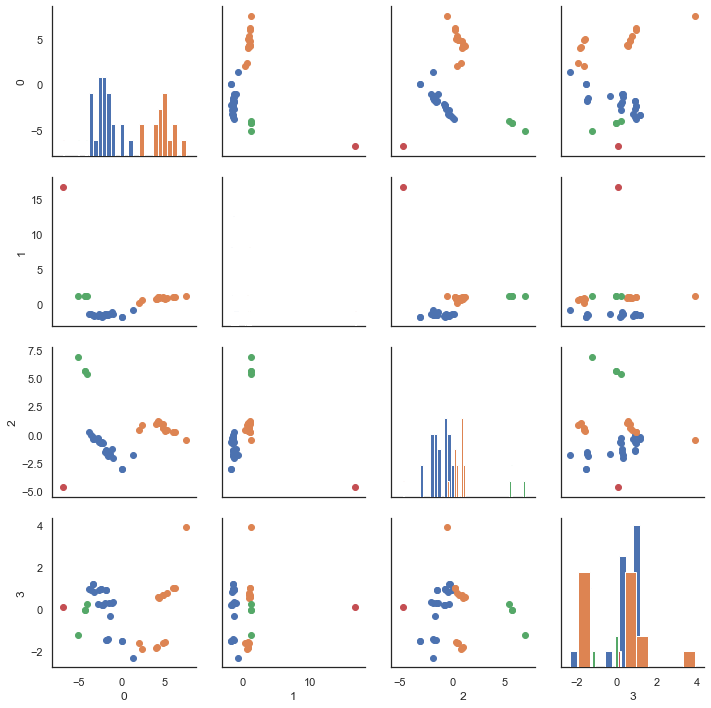

In [43]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

We observe that the one outlier is in its own cluster, there’s 3 or 4 points in the other clusters and the remainder are split into two clusters of greater size.

In [44]:
assert_is_instance(pg.fig, plt.Figure)
assert_true(len(pg.data.columns) >= 4)

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 4 * 10) # 4 clusters with 10 patches in each histogram

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_out, y_out = ax.collections[0].get_offsets().T
    x_in = reduced[clusters == 0, j] # we only check the first cluster
    y_in = reduced[clusters == 0, i]
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = reduced[clusters == 0, j]
    y_in = reduced[clusters == 0, i]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

#### Let's Continue our Analysis and brainstorm
You don't have to write any code in this section, but here's one interpretaion of what we have done.

Let's take a closer look at each cluster.

In [35]:

df = pd.read_csv('delta.csv', index_col='Aircraft')
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean()
print(df_grouped.Accommodation)

Clusters
0    153.625000
1    244.733333
2     44.500000
3     54.000000
Name: Accommodation, dtype: float64


In [36]:
print(df_grouped['Length (ft)'])

Clusters
0    137.048083
1    190.538400
2     84.810750
3    111.000000
Name: Length (ft), dtype: float64


Cluster 3 has only one aircraft:

In [37]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


Airbus A319 VIP is not one of Delta Airline's regular fleet and is one of Airbus corporate jets.

Cluster 2 has four aircrafts.

In [38]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


These are small aircrafts and only have economy seats.

In [39]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


In [40]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


Interesting, Cluster 1 aircrafts do not have first class seating.



In [41]:
print(df.loc[clust1.index, cols_seat])

                          First Class  Business  Eco Comfort  Economy
Aircraft                                                             
Airbus A330-200                     0         1            1        1
Airbus A330-200 (3L2)               0         1            1        1
Airbus A330-200 (3L3)               0         1            1        1
Airbus A330-300                     0         1            1        1
Boeing 747-400 (74S)                0         1            1        1
Boeing 757-200 (75E)                0         1            1        1
Boeing 757-200 (75X)                0         1            1        1
Boeing 767-300 (76G)                0         1            1        1
Boeing 767-300 (76L)                0         1            1        1
Boeing 767-300 (76T)                0         1            1        1
Boeing 767-300 (76Z V.1)            0         1            1        1
Boeing 767-300 (76Z V.2)            0         1            1        1
Boeing 767-400 (76D)

In [42]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

The aircrafts in cluster 0 (except for one aircraft) have first class seating but no business class.



In [43]:
print(df.loc[clust0.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   

### Problem 3
(No Unit Tests in this portion)

Run DBSCAN on Reduced_Delta dataset and compare/discuss the results with K-Means. Please submit your code and output, and write down 3-4 sentences that you observed from the results.

***DONE IN THE OTHER NOTEBOOK***

### Problem 4

Apply t-SNE reduction to delta.csv file and compare/discuss the results with PCA. Please submit your code and output, and write down 3-4 sentences that you observed from the results.

***DONE IN THE OTHER NOTEBOOK***

### Problem 5 (Bonus)

Apply Hiearchical Clustering to delta.csv and observe how physical features are being clustered in ealry leaves at the bottom. Please submit your code and dendrogram graph along with 1-2 sentences interpretation.

***DONE IN THE OTHER NOTEBOOK***